In [89]:
import stable_baselines3
import gym
import numpy as np

# Environement
import gym
from gym import spaces

# Evaluate the environement
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.monitor import Monitor

# Agent
from stable_baselines3 import A2C,DQN
# Policy
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.policies import ActorCriticPolicy


import matplotlib.pyplot as plt
import os

In [2]:
SOLUTION_NAME = "StbBL_Base"
log_dir = SOLUTION_NAME + "/"
os.makedirs(log_dir, exist_ok=False)

FileExistsError: [Errno 17] File exists: 'StbBL_Base/'

# Environement

## Definition

In [34]:
class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    CASE_VIDE = 255
    
    def __init__(self, grid_size=(10,10),nspecies=8):
        # CONTROLES DONNEES
        assert nspecies < 256-1 # pour compatibilité avec uint8. 0 est pris par l'information case vide
        
        # INITILISATIION SUBCLASS
        super().__init__()
        
        
        # PARAMETRES 
        self.grid_size = grid_size
        self.nspecies = nspecies

        
        
        # Define action space
        # ESSAI 1 : NE MARCHE PAS, CE SONT DES VALEURS CONTINUES MEME AVEC dype
#         self.action_space = spaces.Box(low=np.array([0,0,0]),
#                                       high=np.array(self.grid_size + (self.nspecies,)),
#                                       shape=(3,),
#                                       dtype=np.uint8)        
        # ESSAI 2 :
        self.action_space =spaces.MultiDiscrete(self.grid_size + (self.nspecies,))
        
        # Define observation space
        self.observation_space = spaces.Box(low=0,
                                            high=self.nspecies,
                                            shape=grid_size, dtype=np.uint8)
        
        self.state = np.full(self.grid_size,self.CASE_VIDE)
    
    
    def step(self, action):
        # ACTION -> ACTION LOCALE
        x,y,specie = action
        
        
        # CONTROLE
        assert specie != self.CASE_VIDE
        
        done = False # JUSQU'A PREUVE DU CONTRAIRE LA PARTIE CONTINUE
        info = {} # UTILISE POUR DEBUGAGE
        reward = 0
        if self.state[x,y]==self.CASE_VIDE:
            # ACTION VALIDE (CASE LIBRE) CAR ==0            
            self.state[x,y] = specie # ON PLANTE
            reward = 1 # <--------------------------------------------------REWARD NON LEGUME
            if (self.state[x,y]!=self.CASE_VIDE).sum()==0:
                # DANS LE CAS ON IL N'Y A PLUS DE CASES VIDES
                reward = 100 # <--------------------------------------------------REWARD SUCCESS
                done = True 
            
        else:
            # ACTION NON VALIDE CASE DEJA REMPLIE
            reward = -100 # <--------------------------------------------------REWARD FAIL
            done = True
            
        return self.to_observation(), reward, done, info
    
    def reset(self):
        self.state = np.full(self.grid_size,self.CASE_VIDE) # TODO ESSAYER DE FAIRE UN RANDOM A CHAQUE RESET PLUTOT 0, COMME SUGGERE PAR GUILLAUME
        return self.to_observation()
    
    def to_observation(self):
        return self.state.copy()
    
    def render(self,mode="human"):
        return self.to_observation()
        


## Instanciation

In [62]:
env = CustomEnv()
eval_env = CustomEnv(nspecies=1) # Use a separate environement for evaluation
env = Monitor(env, log_dir)

# Agent

In [90]:
# algo_with_policy = DQN(MlpPolicy, env, verbose=2)
algo_with_policy = A2C(ActorCriticPolicy, env, verbose=2,)

Using cpu device
Wrapping the env in a DummyVecEnv.


AssertionError: The algorithm only supports (<class 'gym.spaces.discrete.Discrete'>,) as action spaces but MultiDiscrete([10 10  8]) was provided

## Evaluate initial Agent

In [80]:
# Random Agent, before training
mean_reward, std_reward = evaluate_policy(algo_with_policy, eval_env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-98.00 +/- 0.00


/home/maxime/.pyenv/versions/iarchitect/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


## Train the agent

In [81]:
class MyCallBack(BaseCallback):
    def __init__(self,log_dir,steps_to_print,verbose=0):
        super().__init__()
        self.log_dir = log_dir
        self.steps_to_print = steps_to_print
        
    def _on_step(self) -> bool:
        if self.num_timesteps % self.steps_to_print == 0:
            plt.imshow(self.locals["obs_tensor"].numpy()[0,:,:])
            plt.show()


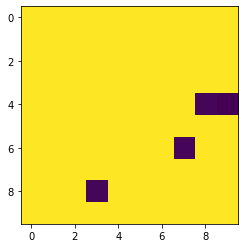

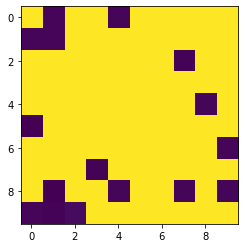

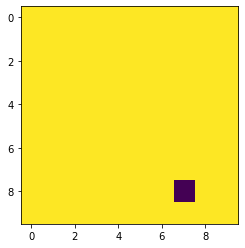

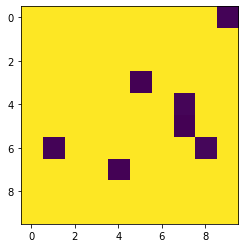

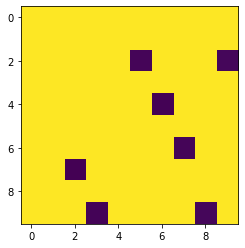

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 10.7     |
|    ep_rew_mean        | -90.3    |
| time/                 |          |
|    fps                | 499      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -6.58    |
|    explained_variance | -0.00421 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -243     |
|    value_loss         | 4.29e+03 |
------------------------------------


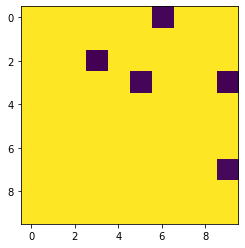

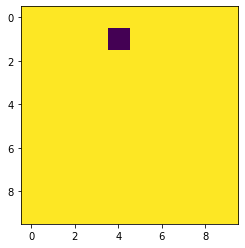

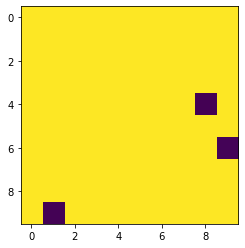

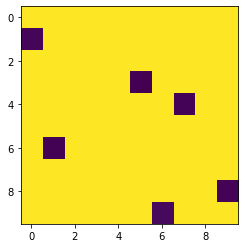

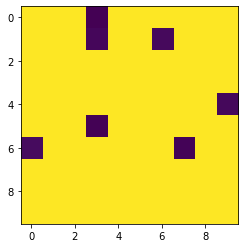

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.4     |
|    ep_rew_mean        | -88.6    |
| time/                 |          |
|    fps                | 503      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -6.59    |
|    explained_variance | 0.00168  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -289     |
|    value_loss         | 4.62e+03 |
------------------------------------


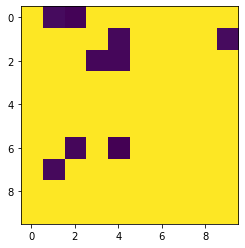

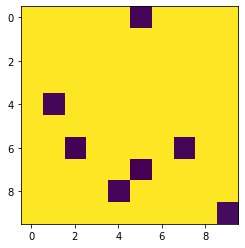

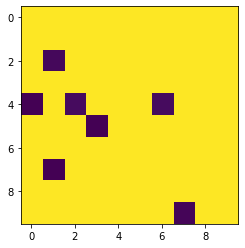

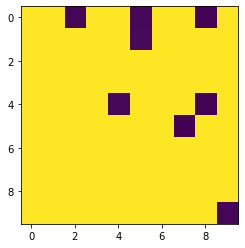

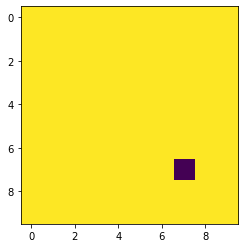

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.8     |
|    ep_rew_mean        | -88.2    |
| time/                 |          |
|    fps                | 502      |
|    iterations         | 300      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -6.56    |
|    explained_variance | 0.0604   |
|    learning_rate      | 0.0007   |
|    n_updates          | 299      |
|    policy_loss        | 16.8     |
|    value_loss         | 8.3      |
------------------------------------


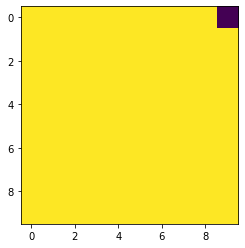

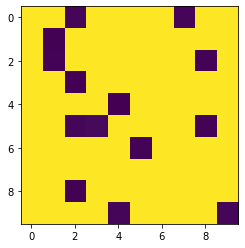

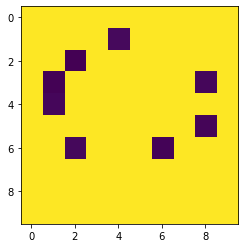

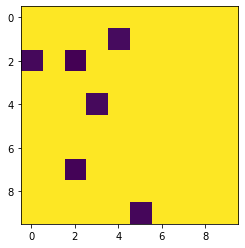

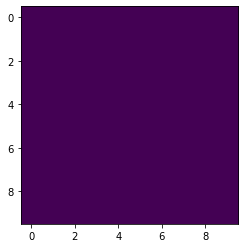

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13       |
|    ep_rew_mean        | -88      |
| time/                 |          |
|    fps                | 497      |
|    iterations         | 400      |
|    time_elapsed       | 4        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -6.56    |
|    explained_variance | -0.0843  |
|    learning_rate      | 0.0007   |
|    n_updates          | 399      |
|    policy_loss        | 18.5     |
|    value_loss         | 8.95     |
------------------------------------


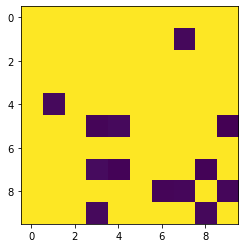

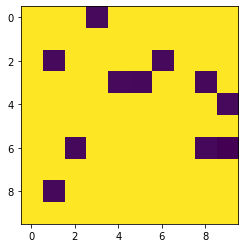

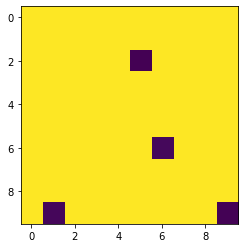

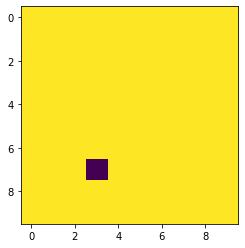

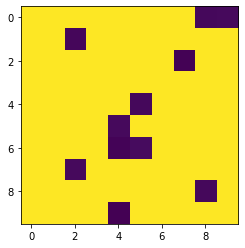

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.5     |
|    ep_rew_mean        | -88.5    |
| time/                 |          |
|    fps                | 497      |
|    iterations         | 500      |
|    time_elapsed       | 5        |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -6.42    |
|    explained_variance | 0.000591 |
|    learning_rate      | 0.0007   |
|    n_updates          | 499      |
|    policy_loss        | 17.1     |
|    value_loss         | 8.26     |
------------------------------------


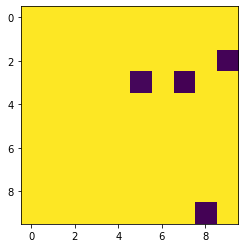

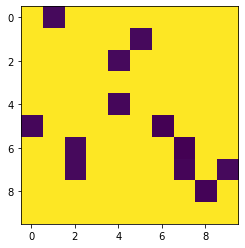

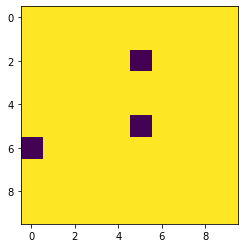

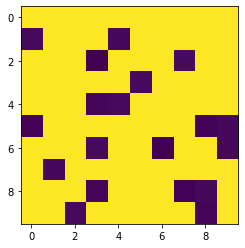

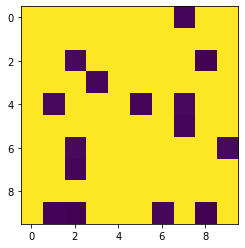

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.7     |
|    ep_rew_mean        | -89.3    |
| time/                 |          |
|    fps                | 482      |
|    iterations         | 600      |
|    time_elapsed       | 6        |
|    total_timesteps    | 3000     |
| train/                |          |
|    entropy_loss       | -6.42    |
|    explained_variance | 0.0271   |
|    learning_rate      | 0.0007   |
|    n_updates          | 599      |
|    policy_loss        | 16.7     |
|    value_loss         | 8.1      |
------------------------------------


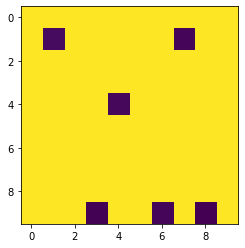

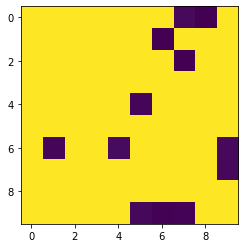

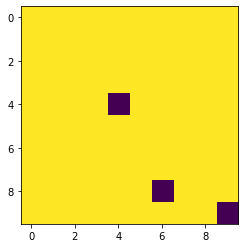

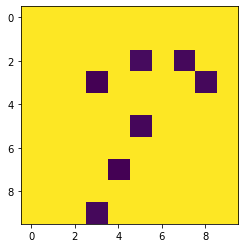

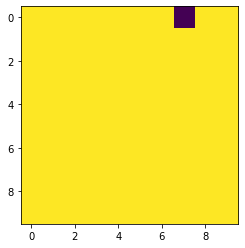

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12       |
|    ep_rew_mean        | -89      |
| time/                 |          |
|    fps                | 479      |
|    iterations         | 700      |
|    time_elapsed       | 7        |
|    total_timesteps    | 3500     |
| train/                |          |
|    entropy_loss       | -6.5     |
|    explained_variance | -0.00623 |
|    learning_rate      | 0.0007   |
|    n_updates          | 699      |
|    policy_loss        | 16.4     |
|    value_loss         | 7.75     |
------------------------------------


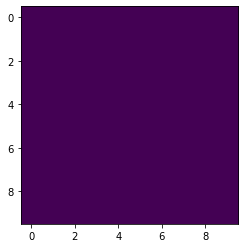

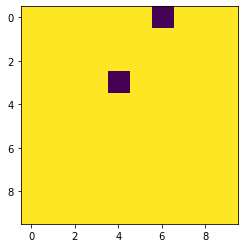

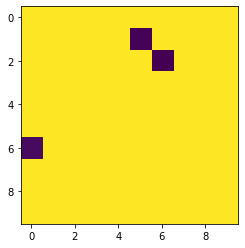

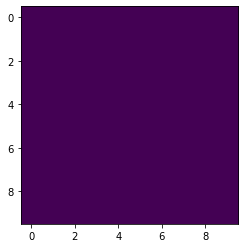

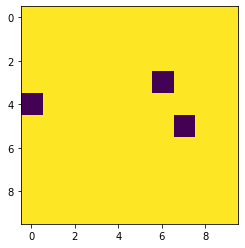

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12       |
|    ep_rew_mean        | -89      |
| time/                 |          |
|    fps                | 479      |
|    iterations         | 800      |
|    time_elapsed       | 8        |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -6.63    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 799      |
|    policy_loss        | 16.7     |
|    value_loss         | 7.64     |
------------------------------------


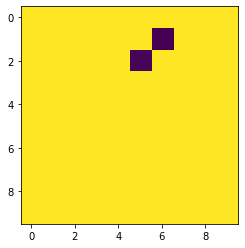

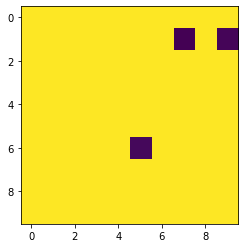

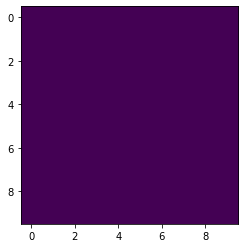

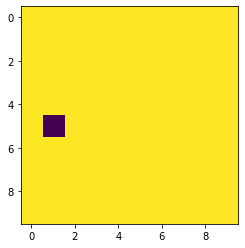

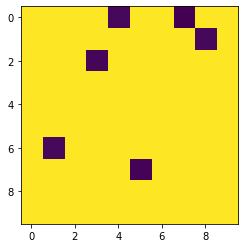

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.3     |
|    ep_rew_mean        | -88.7    |
| time/                 |          |
|    fps                | 480      |
|    iterations         | 900      |
|    time_elapsed       | 9        |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -6.6     |
|    explained_variance | 0.000672 |
|    learning_rate      | 0.0007   |
|    n_updates          | 899      |
|    policy_loss        | -413     |
|    value_loss         | 7.84e+03 |
------------------------------------


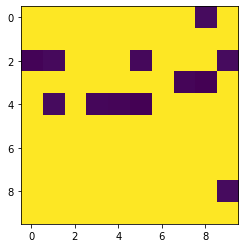

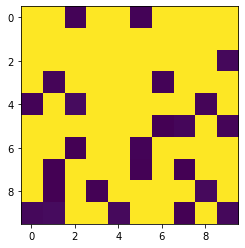

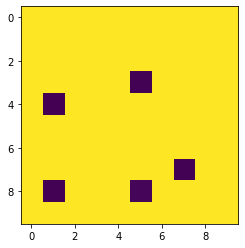

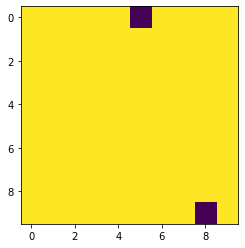

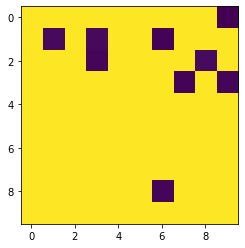

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.7     |
|    ep_rew_mean        | -89.3    |
| time/                 |          |
|    fps                | 481      |
|    iterations         | 1000     |
|    time_elapsed       | 10       |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -6.62    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 999      |
|    policy_loss        | 16.5     |
|    value_loss         | 7.32     |
------------------------------------


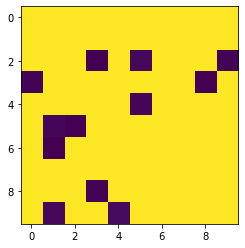

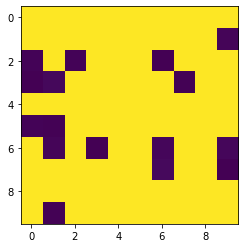

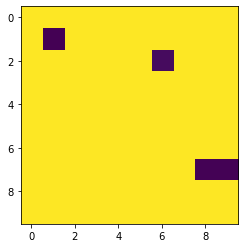

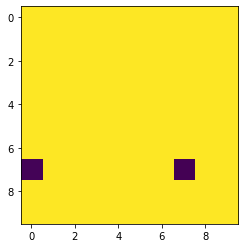

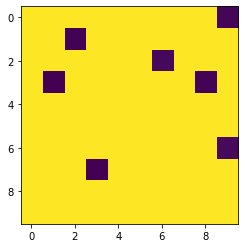

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.9     |
|    ep_rew_mean        | -89.1    |
| time/                 |          |
|    fps                | 482      |
|    iterations         | 1100     |
|    time_elapsed       | 11       |
|    total_timesteps    | 5500     |
| train/                |          |
|    entropy_loss       | -6.45    |
|    explained_variance | 0.00012  |
|    learning_rate      | 0.0007   |
|    n_updates          | 1099     |
|    policy_loss        | -274     |
|    value_loss         | 5.51e+03 |
------------------------------------


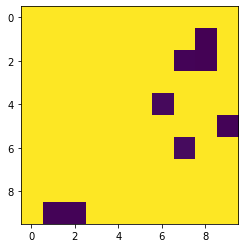

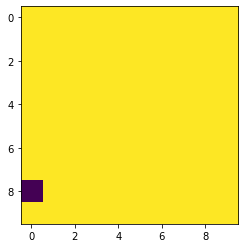

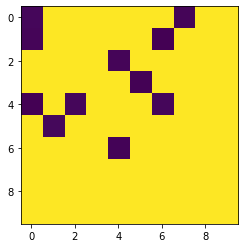

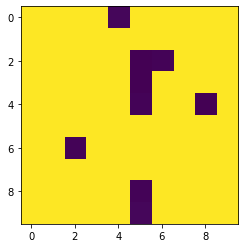

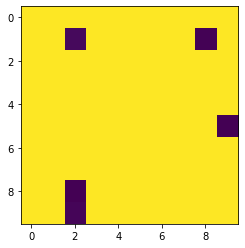

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.2     |
|    ep_rew_mean        | -88.8    |
| time/                 |          |
|    fps                | 482      |
|    iterations         | 1200     |
|    time_elapsed       | 12       |
|    total_timesteps    | 6000     |
| train/                |          |
|    entropy_loss       | -6.46    |
|    explained_variance | 2.53e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 1199     |
|    policy_loss        | -607     |
|    value_loss         | 1.08e+04 |
------------------------------------


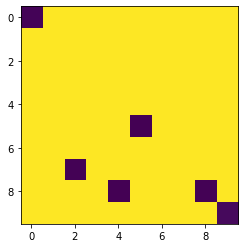

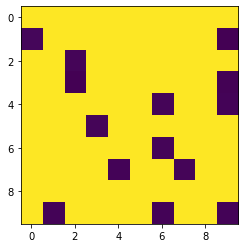

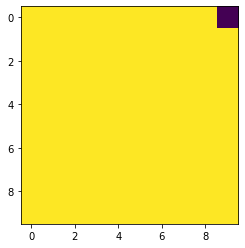

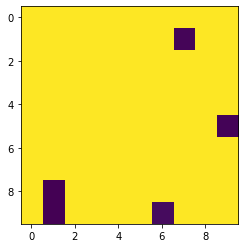

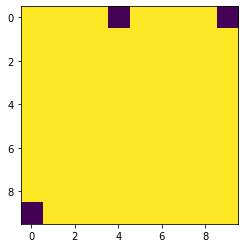

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 12.3      |
|    ep_rew_mean        | -88.7     |
| time/                 |           |
|    fps                | 483       |
|    iterations         | 1300      |
|    time_elapsed       | 13        |
|    total_timesteps    | 6500      |
| train/                |           |
|    entropy_loss       | -6.48     |
|    explained_variance | -4.76e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1299      |
|    policy_loss        | 15.2      |
|    value_loss         | 6.77      |
-------------------------------------


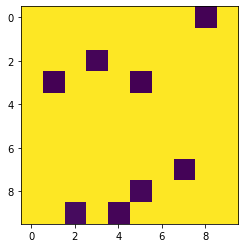

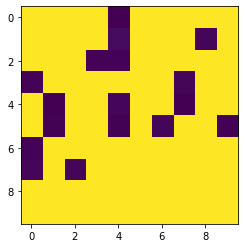

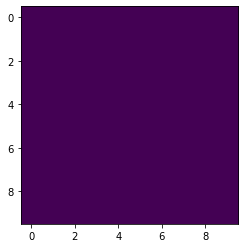

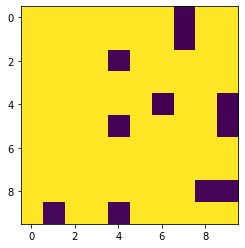

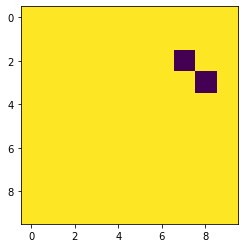

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.9     |
|    ep_rew_mean        | -89.1    |
| time/                 |          |
|    fps                | 484      |
|    iterations         | 1400     |
|    time_elapsed       | 14       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -6.56    |
|    explained_variance | 0.00116  |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | 16.3     |
|    value_loss         | 6.6      |
------------------------------------


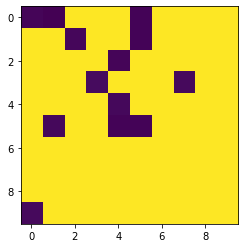

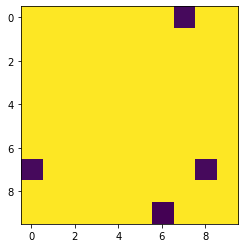

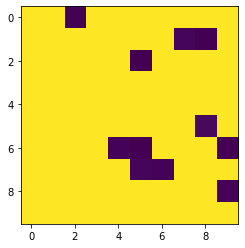

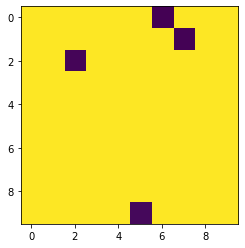

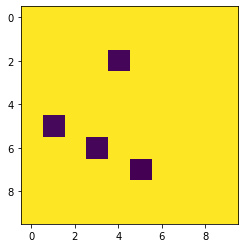

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.3     |
|    ep_rew_mean        | -89.7    |
| time/                 |          |
|    fps                | 482      |
|    iterations         | 1500     |
|    time_elapsed       | 15       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -6.54    |
|    explained_variance | 0.0024   |
|    learning_rate      | 0.0007   |
|    n_updates          | 1499     |
|    policy_loss        | -785     |
|    value_loss         | 1.4e+04  |
------------------------------------


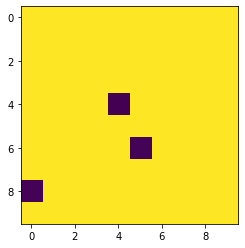

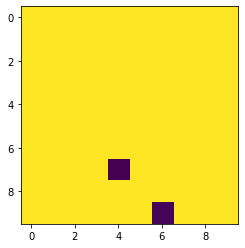

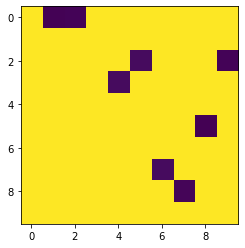

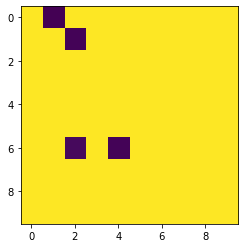

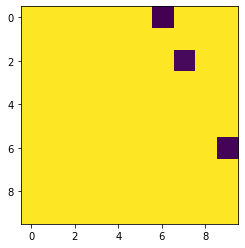

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 11.1      |
|    ep_rew_mean        | -89.9     |
| time/                 |           |
|    fps                | 484       |
|    iterations         | 1600      |
|    time_elapsed       | 16        |
|    total_timesteps    | 8000      |
| train/                |           |
|    entropy_loss       | -6.45     |
|    explained_variance | -4.32e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1599      |
|    policy_loss        | -318      |
|    value_loss         | 5.94e+03  |
-------------------------------------


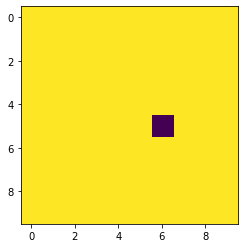

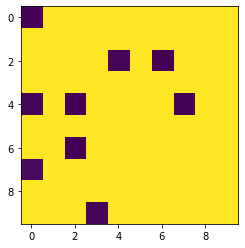

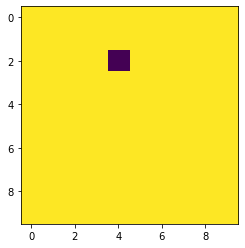

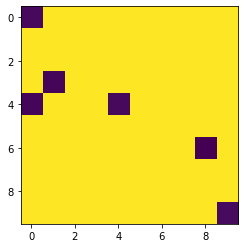

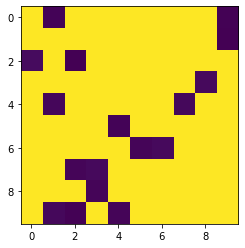

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 11.8     |
|    ep_rew_mean        | -89.2    |
| time/                 |          |
|    fps                | 484      |
|    iterations         | 1700     |
|    time_elapsed       | 17       |
|    total_timesteps    | 8500     |
| train/                |          |
|    entropy_loss       | -6.62    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 1699     |
|    policy_loss        | 15       |
|    value_loss         | 6.19     |
------------------------------------


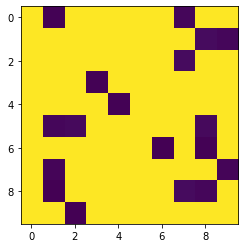

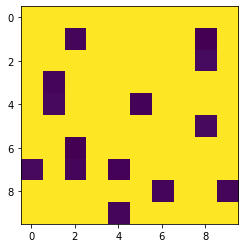

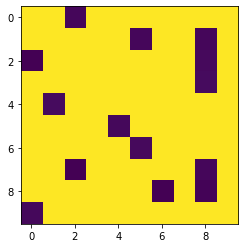

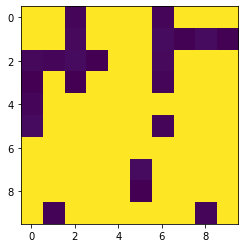

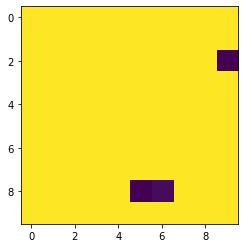

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.6     |
|    ep_rew_mean        | -88.4    |
| time/                 |          |
|    fps                | 485      |
|    iterations         | 1800     |
|    time_elapsed       | 18       |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -6.64    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 1799     |
|    policy_loss        | 15.3     |
|    value_loss         | 5.98     |
------------------------------------


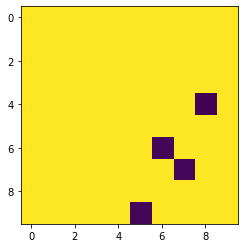

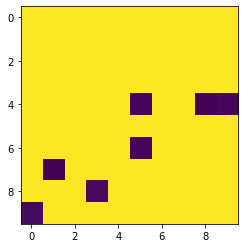

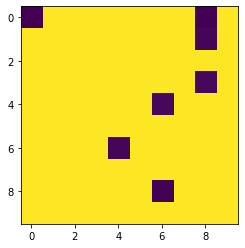

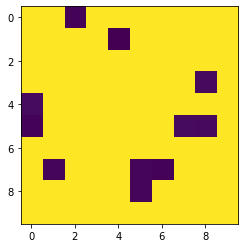

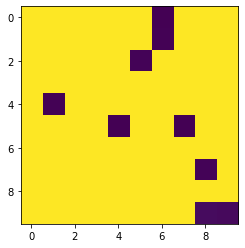

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 12.8      |
|    ep_rew_mean        | -88.2     |
| time/                 |           |
|    fps                | 486       |
|    iterations         | 1900      |
|    time_elapsed       | 19        |
|    total_timesteps    | 9500      |
| train/                |           |
|    entropy_loss       | -6.56     |
|    explained_variance | -0.000937 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1899      |
|    policy_loss        | 15.1      |
|    value_loss         | 5.89      |
-------------------------------------


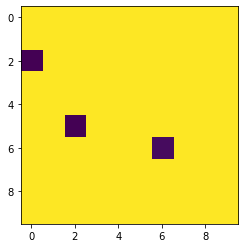

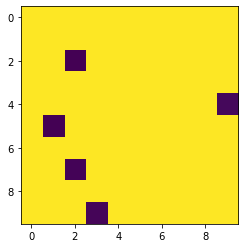

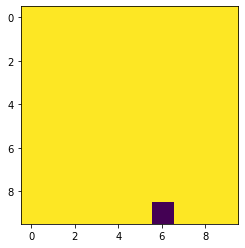

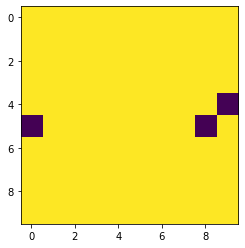

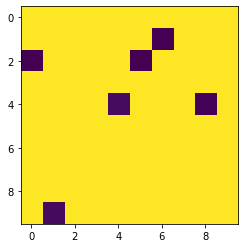

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.5     |
|    ep_rew_mean        | -88.5    |
| time/                 |          |
|    fps                | 487      |
|    iterations         | 2000     |
|    time_elapsed       | 20       |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -6.44    |
|    explained_variance | 4.59e-06 |
|    learning_rate      | 0.0007   |
|    n_updates          | 1999     |
|    policy_loss        | -472     |
|    value_loss         | 9.36e+03 |
------------------------------------


In [82]:
# Train the agent for 10000 steps
callback = MyCallBack(log_dir,100)
algo_with_policy.learn(total_timesteps=10000,callback=callback)

## Evaluate agent 

In [87]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(algo_with_policy, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-99.00 +/- 0.00
